In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
import warnings 
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/data/dataset.zip" -d "/content"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/dataset/validation/Cat/6091.png  
  inflating: /content/dataset/validation/Cat/6092.png  
  inflating: /content/dataset/validation/Cat/6098.png  
  inflating: /content/dataset/validation/Cat/6103.png  
  inflating: /content/dataset/validation/Cat/6104.png  
  inflating: /content/dataset/validation/Cat/6108.png  
  inflating: /content/dataset/validation/Cat/6109.png  
  inflating: /content/dataset/validation/Cat/6111.png  
  inflating: /content/dataset/validation/Cat/6115.png  
  inflating: /content/dataset/validation/Cat/6122.png  
  inflating: /content/dataset/validation/Cat/6128.png  
  inflating: /content/dataset/validation/Cat/6130.png  
  inflating: /content/dataset/validation/Cat/6132.png  
  inflating: /content/dataset/validation/Cat/614.png  
  inflating: /content/dataset/validation/Cat/6140.png  
  inflating: /content/dataset/validation/Cat/6143.png  
  inflating: /content/dataset/validation/Cat/6146.png  
  

In [4]:
# set the image size, batch size and shuffle
train_dir = os.path.join('/content/dataset/train')
validation_dir = os.path.join('/content/dataset/validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 17498 files belonging to 2 classes.
Found 7500 files belonging to 2 classes.


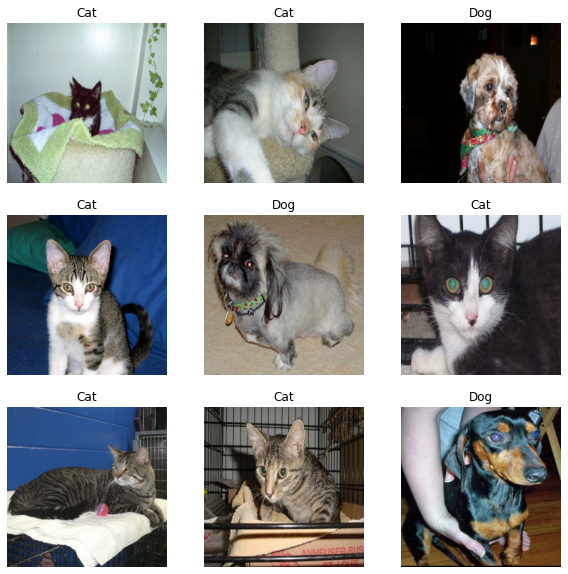

In [5]:
# show some of the images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# set the variables that will be used later in the training process
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
# print number of batches
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 188
Number of test batches: 47


In [8]:
# autotune the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

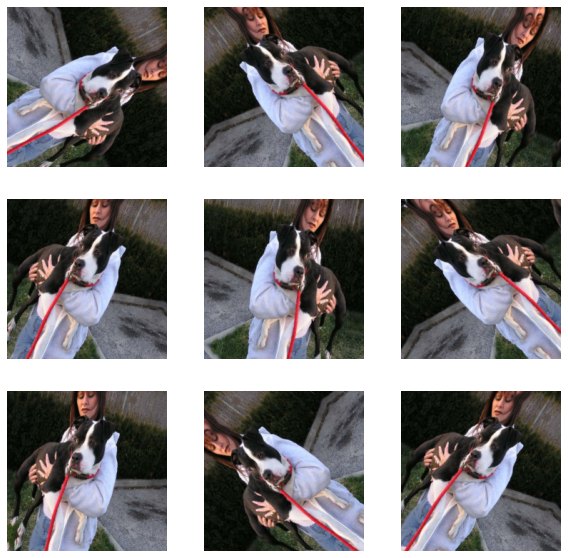

In [10]:
# show images that was augmented
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
rescale = tf.keras.layers.Rescaling(1./255, offset=-1)

In [12]:
# Create the base model from the pre-trained model VGG16
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator

# base model
INPUT_SIZE = 128
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape=(INPUT_SIZE,INPUT_SIZE,3))
for layer in vgg16.layers:
    layer.trainable=False 

from keras.models import Model

# create pipeline
input_ = vgg16.input
output_=vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1,activation ='sigmoid')(last_layer)
model = Model(input_,last_layer)

BATCH_SIZE = 32
STEPS_PER_EPOCH = 200
EPOCHS = 20

# optimize relate to accuracy
model.compile(optimizer ='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

# train the model
training_set = training_data_generator.flow_from_directory('/content/dataset/train/', target_size=(INPUT_SIZE,INPUT_SIZE),
                                                           batch_size = BATCH_SIZE, class_mode = 'binary')
test_set = testing_data_generator.flow_from_directory('/content/dataset/validation/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')
model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose =1)

58900480/58889256 [==============================] - 0s 0us/step
Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/20
200/200 [==============================] - 34s 110ms/step - loss: 0.3501 - accuracy: 0.8417
Epoch 2/20
200/200 [==============================] - 22s 108ms/step - loss: 0.2647 - accuracy: 0.8863
Epoch 3/20
200/200 [==============================] - 20s 101ms/step - loss: 0.2466 - accuracy: 0.8989
Epoch 4/20
200/200 [==============================] - 21s 106ms/step - loss: 0.2285 - accuracy: 0.9120
Epoch 5/20
200/200 [==============================] - 21s 102ms/step - loss: 0.2083 - accuracy: 0.9162
Epoch 6/20
200/200 [==============================] - 21s 103ms/step - loss: 0.2158 - accuracy: 0.9135
Epoch 7/20
200/200 [==============================] - 21s 103ms/step - loss: 0.2052 - accuracy: 0.9144
Epoch 8/20
200/200 [==============================] - 21s 104ms/step - loss: 0.2025 - accuracy: 0.9177
Epoch 9/20
200/200 [======

## Model Evaluation

In [13]:
# print performance metrics
score = model.evaluate_generator(test_set,len(test_set))

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric,score[idx]))

loss: 0.23716551065444946
accuracy: 0.8982666730880737


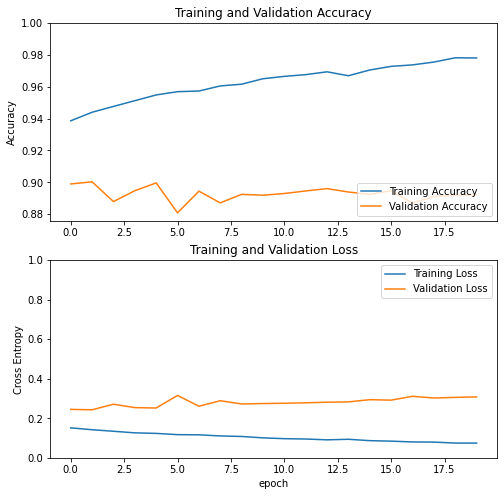

In [14]:
# loss and accuracy graphs
history = model.fit(training_set,
                    epochs=20,
                    validation_data=test_set, verbose = 0)# burası belki hata çıkarır

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =  history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
